# Datalab: A unified audit to detect all kinds of issues in data and labels.

`Datalab` helps you identify various issues in your machine learning datasets, such as noisy labels, outliers, (near) duplicates, and other types of problems that commonly occur in real-world data that may negatively impact the performance of your machine learning model if not addressed. `Datalab` utilizes *any* ML model you have already trained for your data to diagnose these issues, it only requires access to either: (probabilistic) predictions from your model or its learned representations of the data.


**Overview of what we'll do in this tutorial:**

- Compute out-of-sample predicted probabilities for a sample dataset using cross-validation.
- Use `Datalab` to identify issues such as noisy labels, outliers, (near) duplicates, and other types of problems 
- View the issue summaries and other information about our sample dataset

You can easily replace our demo dataset with your own image/text/tabular/audio/etc dataset, and then run the same code to discover what sort of issues lurk within it!

<div class="alert alert-info">
Quickstart
<br/>
    
Already have (out-of-sample) `pred_probs` from a model trained on an existing set of labels? Maybe you have some `features` as well? Run the code below to examine your dataset for multiple types of issues.

<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```ipython3 
from cleanlab import Datalab

lab = Datalab(data=your_dataset, label_name="column_name_of_labels")

lab.find_issues(features=your_feature_matrix, pred_probs=your_pred_probs)

lab.report()
```
   
</div>
</div>

## 1. Install and import required dependencies

`Datalab` has additional dependencies that are not included in the standard installation of cleanlab.

You can use pip to install all packages required for this tutorial as follows:

```
!pip install matplotlib 
!pip install cleanlab[datalab]

# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [1]:
# Package installation (hidden on docs website).
dependencies = ["cleanlab", "matplotlib", "datasets"]  # TODO: make sure this list is updated

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

In [2]:
# TODO: remove cell before merging to master
# !pip install git+https://github.com/cleanlab/cleanlab.git#egg=cleanlab[datalab]

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

from cleanlab import Datalab

## 2. Create and load the data (can skip these details)

We'll load a toy classification dataset for this tutorial. The dataset has two numerical features and a label column with three classes.

<details><summary>See the code for data generation. **(click to expand)**</summary>
    
```ipython3
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

SEED = 123
np.random.seed(SEED)

BINS = {
    "low": [-np.inf, 3.3],
    "mid": [3.3, 6.6],
    "high": [6.6, +np.inf],
}

BINS_MAP = {
    "low": 0,
    "mid": 1,
    "high": 2,
}


def create_data():

    X = np.random.rand(250, 2) * 5
    y = np.sum(X, axis=1)
    # Map y to bins based on the BINS dict
    y_bin = np.array([k for y_i in y for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_bin_idx = np.array([BINS_MAP[k] for k in y_bin])

    # Split into train and test
    X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(
        X, y_bin, y_bin_idx, test_size=0.5, random_state=SEED
    )

    # Add several (5) out-of-distribution points. Sliding them along the decision boundaries
    # to make them look like they are out-of-frame
    X_out = np.array(
        [
            [-1.5, 3.0],
            [-1.75, 6.5],
            [1.5, 7.2],
            [2.5, -2.0],
            [5.5, 7.0],
        ]
    )
    # Add a near duplicate point to the last outlier, with some tiny noise added
    near_duplicate = X_out[-1:] + np.random.rand(1, 2) * 1e-6
    X_out = np.concatenate([X_out, near_duplicate])

    y_out = np.sum(X_out, axis=1)
    y_out_bin = np.array([k for y_i in y_out for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_out_bin_idx = np.array([BINS_MAP[k] for k in y_out_bin])

    # Add to train
    X_train = np.concatenate([X_train, X_out])
    y_train = np.concatenate([y_train, y_out])
    y_train_idx = np.concatenate([y_train_idx, y_out_bin_idx])

    # Add an exact duplicate example to the training set
    exact_duplicate_idx = np.random.randint(0, len(X_train))
    X_duplicate = X_train[exact_duplicate_idx, None]
    y_duplicate = y_train[exact_duplicate_idx, None]
    y_duplicate_idx = y_train_idx[exact_duplicate_idx, None]

    # Add to train
    X_train = np.concatenate([X_train, X_duplicate])
    y_train = np.concatenate([y_train, y_duplicate])
    y_train_idx = np.concatenate([y_train_idx, y_duplicate_idx])

    py = np.bincount(y_train_idx) / float(len(y_train_idx))
    m = len(BINS)

    noise_matrix = generate_noise_matrix_from_trace(
        m,
        trace=0.9 * m,
        py=py,
        valid_noise_matrix=True,
        seed=SEED,
    )

    noisy_labels_idx = generate_noisy_labels(y_train_idx, noise_matrix)

    # TODO: Add noise to test set when we support extra splits in Datalab

    noisy_labels = np.array([list(BINS_MAP.keys())[i] for i in noisy_labels_idx])

    return X_train, y_train_idx, noisy_labels, noisy_labels_idx, X_out, X_duplicate
```

</details>

In [4]:
from sklearn.model_selection import train_test_split

from cleanlab.benchmarking.noise_generation import (
    generate_noise_matrix_from_trace,
    generate_noisy_labels,
)

SEED = 123
np.random.seed(SEED)

BINS = {
    "low": [-np.inf, 3.3],
    "mid": [3.3, 6.6],
    "high": [6.6, +np.inf],
}

BINS_MAP = {
    "low": 0,
    "mid": 1,
    "high": 2,
}


def create_data():

    X = np.random.rand(250, 2) * 5
    y = np.sum(X, axis=1)
    # Map y to bins based on the BINS dict
    y_bin = np.array([k for y_i in y for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_bin_idx = np.array([BINS_MAP[k] for k in y_bin])

    # Split into train and test
    X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(
        X, y_bin, y_bin_idx, test_size=0.5, random_state=SEED
    )

    # Add several (5) out-of-distribution points. Sliding them along the decision boundaries
    # to make them look like they are out-of-frame
    X_out = np.array(
        [
            [-1.5, 3.0],
            [-1.75, 6.5],
            [1.5, 7.2],
            [2.5, -2.0],
            [5.5, 7.0],
        ]
    )
    # Add a near duplicate point to the last outlier, with some tiny noise added
    near_duplicate = X_out[-1:] + np.random.rand(1, 2) * 1e-6
    X_out = np.concatenate([X_out, near_duplicate])

    y_out = np.sum(X_out, axis=1)
    y_out_bin = np.array([k for y_i in y_out for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_out_bin_idx = np.array([BINS_MAP[k] for k in y_out_bin])

    # Add to train
    X_train = np.concatenate([X_train, X_out])
    y_train = np.concatenate([y_train, y_out])
    y_train_idx = np.concatenate([y_train_idx, y_out_bin_idx])

    # Add an exact duplicate example to the training set
    exact_duplicate_idx = np.random.randint(0, len(X_train))
    X_duplicate = X_train[exact_duplicate_idx, None]
    y_duplicate = y_train[exact_duplicate_idx, None]
    y_duplicate_idx = y_train_idx[exact_duplicate_idx, None]

    # Add to train
    X_train = np.concatenate([X_train, X_duplicate])
    y_train = np.concatenate([y_train, y_duplicate])
    y_train_idx = np.concatenate([y_train_idx, y_duplicate_idx])

    py = np.bincount(y_train_idx) / float(len(y_train_idx))
    m = len(BINS)

    noise_matrix = generate_noise_matrix_from_trace(
        m,
        trace=0.9 * m,
        py=py,
        valid_noise_matrix=True,
        seed=SEED,
    )

    noisy_labels_idx = generate_noisy_labels(y_train_idx, noise_matrix)

    # TODO: Add noise to test set when we support extra splits in Datalab

    noisy_labels = np.array([list(BINS_MAP.keys())[i] for i in noisy_labels_idx])

    return X_train, y_train_idx, noisy_labels, noisy_labels_idx, X_out, X_duplicate


In [5]:
X_train, y_train_idx, noisy_labels, noisy_labels_idx, X_out, X_duplicate = create_data()

We make a scatter plot of the features, with a color corresponding to the observed labels. Incorrect given labels are highlighted in red if they do not match the true label, outliers highlighted with an a black cross, and duplicates highlighted with a cyan cross.

<details><summary>See the code to visualize the data. **(click to expand)**</summary>
    
```ipython3
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

import matplotlib.pyplot as plt

def plot_data(X_train, y_train_idx, noisy_labels_idx, X_out, X_duplicate):
    # Plot data with clean labels and noisy labels, use BINS_MAP for the legend
    fig, ax = plt.subplots(figsize=(8, 6))
    for k, v in BINS_MAP.items():
        ax.scatter(X_train[noisy_labels_idx == v, 0], X_train[noisy_labels_idx == v, 1], label=k)
    ax.set_title("Noisy labels")
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")

    # Plot true boundaries (x+y=3.3, x+y=6.6)
    ax.set_xlim(-3.5, 8.5)
    ax.set_ylim(-3.5, 8.5)
    ax.plot([-0.7, 4.0], [4.0, -0.7], color="k", linestyle="--", alpha=0.5)
    ax.plot([-0.7, 7.3], [7.3, -0.7], color="k", linestyle="--", alpha=0.5)

    # Draw red circles around the points that are misclassified (i.e. the points that are in the wrong bin)
    for i, (X, y) in enumerate(zip([X_train, X_train], [y_train_idx, noisy_labels_idx])):
        for j, (k, v) in enumerate(BINS_MAP.items()):
            ax.plot(
                X[(y == v) & (y != y_train_idx), 0],
                X[(y == v) & (y != y_train_idx), 1],
                "o",
                markerfacecolor="none",
                markeredgecolor="red",
                markersize=14,
                markeredgewidth=2.5,
                alpha=0.5,
                **{"label": "Label error" if i == 1 and j == 0 else None}
            )

    ax.scatter(X_out[:, 0], X_out[:, 1], color="k", marker="x", s=100, linewidth=2, label="Outlier")

    # Plot the exact duplicate
    ax.scatter(
        X_duplicate[:, 0],
        X_duplicate[:, 1],
        color="c",
        marker="x",
        s=100,
        linewidth=2,
        label="Exact Duplicate",
    )
    ax.legend()
    plt.tight_layout()
```
    
</details>

In [6]:
import matplotlib.pyplot as plt

def plot_data(X_train, y_train_idx, noisy_labels_idx, X_out, X_duplicate):
    # Plot data with clean labels and noisy labels, use BINS_MAP for the legend
    fig, ax = plt.subplots(figsize=(8, 6))
    for k, v in BINS_MAP.items():
        ax.scatter(X_train[noisy_labels_idx == v, 0], X_train[noisy_labels_idx == v, 1], label=k)
    ax.set_title("Noisy labels")
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")

    # Plot true boundaries (x+y=3.3, x+y=6.6)
    ax.set_xlim(-3.5, 8.5)
    ax.set_ylim(-3.5, 8.5)
    ax.plot([-0.7, 4.0], [4.0, -0.7], color="k", linestyle="--", alpha=0.5)
    ax.plot([-0.7, 7.3], [7.3, -0.7], color="k", linestyle="--", alpha=0.5)

    # Draw red circles around the points that are misclassified (i.e. the points that are in the wrong bin)
    for i, (X, y) in enumerate(zip([X_train, X_train], [y_train_idx, noisy_labels_idx])):
        for j, (k, v) in enumerate(BINS_MAP.items()):
            ax.plot(
                X[(y == v) & (y != y_train_idx), 0],
                X[(y == v) & (y != y_train_idx), 1],
                "o",
                markerfacecolor="none",
                markeredgecolor="red",
                markersize=14,
                markeredgewidth=2.5,
                alpha=0.5,
                **{"label": "Label error" if i == 1 and j == 0 else None}
            )

    ax.scatter(X_out[:, 0], X_out[:, 1], color="k", marker="x", s=100, linewidth=2, label="Outlier")

    # Plot the exact duplicate
    ax.scatter(
        X_duplicate[:, 0],
        X_duplicate[:, 1],
        color="c",
        marker="x",
        s=100,
        linewidth=2,
        label="Exact Duplicate",
    )
    ax.legend()
    plt.tight_layout()

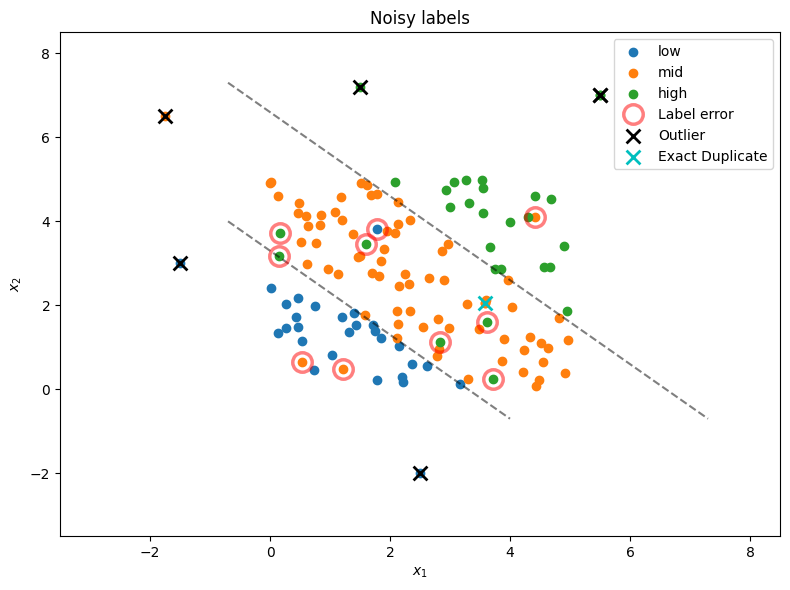

In [7]:
plot_data(X_train, y_train_idx, noisy_labels_idx, X_out, X_duplicate)

In real-world scenarios, you won't know the true labels or the distribution of the features, so we won't use these in this tutorial, except for evaluation purposes.



`Datalab` has several ways of loading the data.
In this case, we'll simply wrap the training features and noisy labels in a dictionary so that we can pass it to `Datalab`.

In [8]:
data = {"X": X_train, "y": noisy_labels}

Other supported data formats for `Datalab` include: [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) and [HuggingFace Datasets](https://huggingface.co/docs/datasets/index). `Datalab` works across most data modalities (image, text, tabular, audio, etc). It is intended to find issues that commonly occur in datasets for which you have trained a supervised ML model, regardless of the type of data.

## 3. Get out-of-sample predicted probabilities from a classifier

To detect certain types of issues in classification data (e.g. label errors), `Datalab` relies on predicted class probabilities from a trained model. Ideally, the prediction for each example should be out-of-sample (to avoid overfitting), coming from a copy of the model that was not trained on this example. 

This tutorial uses a simple logistic regression model 
and the `cross_val_predict()` function from scikit-learn to generate out-of-sample predicted class probabilities for every example in the training set. You can replace this with *any* other classifier model and train it with cross-validation to get out-of-sample predictions.

In [9]:
model = LogisticRegression()
pred_probs = cross_val_predict(
    estimator=model, X=data["X"], y=data["y"], cv=5, method="predict_proba"
)

## 4. Use Datalab to find issues in the dataset

We create a `Datalab` (you should only have one per dataset) and provide it with the data object and name of the label column in the data object (only classification datasets are supported for now).

All that is need to audit your data is to call `find_issues()`. This method accepts various inputs like: predicted class probabilities, numeric feature representations of the data. The more information you provide here, the more thoroughly `Datalab` will audit your data! 

Note that `features` should be some numeric representation of each example, either obtained through preprocessing transformation of your raw data or embeddings from a (pre)trained model. In this case, our data is already entirely numeric so we just provide the features directly.

In [10]:
lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, features=data["X"])

Finding label issues ...
--------------------------------------------------------
|  Generating a Cleanlab Dataset Health Summary        |
|   for your dataset with 132 examples and 3 classes.  |
|  Note, Cleanlab is not a medical doctor... yet.      |
--------------------------------------------------------

Overall Class Quality and Noise across your dataset (below)
------------------------------------------------------------ 



,Class Name,Class Index,Label Issues,Inverse Label Issues,Label Noise,Inverse Label Noise,Label Quality Score
0,high,0,6,1,0.206897,0.041667,0.793103
1,low,1,2,3,0.071429,0.103448,0.928571
2,mid,2,4,8,0.053333,0.101266,0.946667



Class Overlap. In some cases, you may want to merge classes in the top rows (below)
-----------------------------------------------------------------------------------



,Class Name A,Class Name B,Class Index A,Class Index B,Num Overlapping Examples,Joint Probability
0,high,mid,0,2,7,0.053030
1,low,mid,1,2,5,0.037879
2,high,low,0,1,0,0.000000



 * Overall, about 9% (12 of the 132) labels in your dataset have potential issues.
 ** The overall label health score for this dataset is: 0.91.

Generated with <3 from Cleanlab.

Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Audit complete. 21 issues found in the dataset.


/Users/huiwengoh/Documents/Cleanlab/Code/branches/datalab/cleanlab/cleanlab/datalab/knn.py:77: UserWarning: n_neighbors 5 does not match n_neighbors 10 used to fit knn. Most likely an existing NearestNeighbors object was passed in, but a different n_neighbors was specified. Using the n_neighbors found in the existing KNN search object.
  warnings.warn(


Now let's review the results of this audit using `report()`.
This provides a high-level summary of each type of issue found in the dataset.

In [11]:
lab.report()

Here is a summary of the different kinds of issues found in the data:

    issue_type    score  num_issues
         label 0.909091          11
       outlier 0.522080           6
near_duplicate 0.246459           4

(Note: A lower score indicates a more severe issue across all examples in the dataset.)


------------------------------------------- label issues -------------------------------------------

About this issue:
	Examples whose given label is estimated to be potentially 
    incorrect (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 11
Overall dataset quality in terms of this issue: : 0.9091

Examples representing most severe instances of this issue:
     is_label_issue  label_score given_label predicted_label
77             True     0.006939        high             mid
7              True     0.007830         low             mid
40             True     0.014826         mid             low
107            True     0.0

## 5. View issue summaries and additional information regarding the dataset

There are several methods to get more details about a particular issue.

The `get_summary()` method fetches summary statistics regarding how severe each type of issue is overall across the whole dataset.

In [12]:
lab.get_summary()

,issue_type,score,num_issues
0,label,0.909091,11
1,outlier,0.522080,6
2,near_duplicate,0.246459,4


We can also pass the type of issue as a argument to the `get_summary()` method to get the summary for a particular issue. For example, we can pass in `label` as an argument to only get the summary regarding label issues.

In [13]:
lab.get_summary("label")

,issue_type,score,num_issues
0,label,0.909091,11


The `get_issues()` method returns information for each individual example about: whether or not it is plagued by this issue, as well as a quality score for how severe this issue appears to be. 

In [14]:
lab.get_issues().head()

,is_label_issue,label_score,is_outlier_issue,outlier_score,is_near_duplicate_issue,near_duplicate_score
0,False,0.864232,False,0.586131,False,0.235095
1,False,0.825563,False,0.548979,False,0.221560
2,False,0.533367,False,0.622256,False,0.199185
3,False,0.755724,False,0.499498,False,0.179601
4,True,0.133588,False,0.632385,False,0.292800


Similar to above, we can pass the type of issue as a argument to `get_issues()` to get the information for that particular issue.

Lower scores indicate more severe instances of the issue, so you can sort by these values to see the most concerning examples in your dataset for each type of issue. Here we show an example of how to get the examples that have been identified as having the most severe label issues.

In [15]:
examples_w_issue = (
    lab.get_issues("label")
    .query("is_label_issue")
    .sort_values("label_score")
)

examples_w_issue.head()

,is_label_issue,label_score,given_label,predicted_label
77,True,0.006939,high,mid
7,True,0.007830,low,mid
40,True,0.014826,mid,low
107,True,0.021220,high,mid
120,True,0.026403,high,mid


Looking at the labels for some of these top-ranked examples, we find their given label was indeed incorrect!

Additional information (statistics, intermediate results, etc) related to a particular issue check can be accessed via `get_info(issue_name)`.

In [16]:
lab.get_info("label")

{'num_label_issues': 11,
 'average_label_quality': 0.6852252801299483,
 'given_label': array(['mid', 'mid', 'low', 'high', 'high', 'mid', 'high', 'low', 'mid',
        'mid', 'mid', 'low', 'mid', 'mid', 'mid', 'mid', 'mid', 'high',
        'high', 'mid', 'low', 'mid', 'high', 'mid', 'mid', 'mid', 'low',
        'low', 'mid', 'low', 'high', 'high', 'mid', 'low', 'mid', 'high',
        'high', 'high', 'low', 'mid', 'mid', 'mid', 'mid', 'high', 'mid',
        'mid', 'mid', 'high', 'low', 'low', 'mid', 'mid', 'mid', 'high',
        'mid', 'mid', 'low', 'low', 'high', 'mid', 'low', 'mid', 'mid',
        'mid', 'mid', 'low', 'mid', 'mid', 'mid', 'high', 'mid', 'mid',
        'low', 'mid', 'mid', 'high', 'mid', 'high', 'high', 'mid', 'mid',
        'high', 'low', 'mid', 'low', 'mid', 'mid', 'mid', 'low', 'mid',
        'mid', 'high', 'mid', 'low', 'mid', 'low', 'low', 'low', 'low',
        'mid', 'high', 'low', 'mid', 'mid', 'low', 'mid', 'mid', 'high',
        'mid', 'high', 'mid', 'mid', 'm

## 6. Get more information from Datalab attributes

Some summaries are also directly accessible as attributes of the `Datalab` instance.

The summary of all issues can be accessed by the `issue_summary` method. This is equivalent to calling `lab.get_summary()`.

In [17]:
lab.issue_summary

,issue_type,score,num_issues
0,label,0.909091,11
1,outlier,0.522080,6
2,near_duplicate,0.246459,4


Details about the quality of each example can be accessed by the `issues` method. This is equivalent to calling `lab.get_issues()`.

In [18]:
lab.issues.head()

,is_label_issue,label_score,is_outlier_issue,outlier_score,is_near_duplicate_issue,near_duplicate_score
0,False,0.864232,False,0.586131,False,0.235095
1,False,0.825563,False,0.548979,False,0.221560
2,False,0.533367,False,0.622256,False,0.199185
3,False,0.755724,False,0.499498,False,0.179601
4,True,0.133588,False,0.632385,False,0.292800


Lastly, you can get all sorts of information regarding your dataset using the `info` attribute. This will not be printed in this example as the return is large but feel free to check it out yourself!

In [19]:
# lab.info 

`Datalab` makes it very easy to check your datasets for all sorts of issues that are important to deal with for training robust models. 

For more information, check out this [TODO: examples notebook] and [TODO: advanced tutorial notebook]